# Make plots and reports for project

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV


In [82]:
airbnb = pd.read_pickle("./data/geos/airbnb.pkl")

trains = pd.read_pickle("./data/geos/trains.pkl")
spots = pd.read_pickle("./data/geos/spots.pkl")
food = pd.read_pickle("./data/geos/food.pkl")
cafes = pd.read_pickle("./data/geos/cafes.pkl")
bodegas = pd.read_pickle("./data/geos/bodegas.pkl")
bars = pd.read_pickle("./data/geos/bars.pkl")

nyc = pd.read_pickle("./data/geos/nyc.pkl")
jersey = pd.read_pickle("./data/geos/jersey.pkl")
lines = pd.read_pickle("./data/geos/lines.pkl")


In [83]:
def make_base_plot():
    ax = nyc.plot(figsize=(10,10), alpha=0.08)
    jersey.plot(ax=ax, alpha=0.025, cmap="gray")
    lines.plot(ax=ax, alpha=0.16, edgecolor="green")

    plt.xlim(-74.04, -73.9)
    plt.ylim(40.65, 40.79)

    plt.xticks((), ())
    plt.yticks((), ())

    return ax

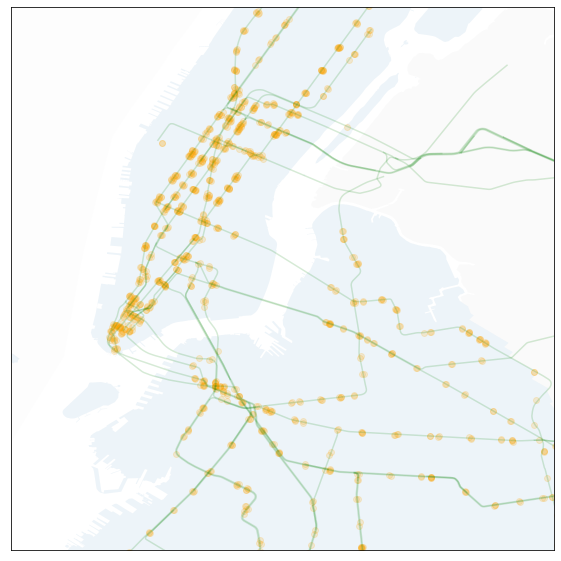

In [84]:
ax = make_base_plot()

trains.drop_duplicates(["geometry"]).plot(ax=ax, alpha=0.16, c="orange");

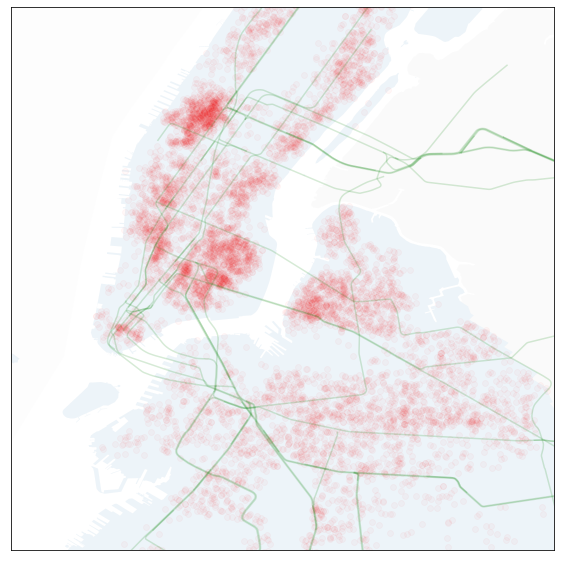

In [85]:
ax = make_base_plot()

airbnb.drop_duplicates(subset=["id", "geometry"]).plot(ax=ax, alpha=0.0275, color="red")


In [90]:
def get_fit_data(input_data, column_list):
    
    used_data = input_data[[*column_list,"id","log_price"]].drop(columns=['id'])
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        used_data.loc[:, used_data.columns != 'log_price'], used_data.log_price, test_size=0.2
    )
    
#     reserved_ids = []

#     test_ids = []

#     test_input = {
#         (30,45): 4,
#         (20,30): 4,
#         (10,20): 4,
#         (0,10): 4
#     }

#     for cur_key, cur_percentage in test_input.items():
#         sub_data = input_data[(input_data.month_count > cur_key[0]) & (input_data.month_count <= cur_key[1])]
#         cur_id_list = list(sub_data.id.unique())

#         random.shuffle(cur_id_list)

#         cur_value = int(np.round( len(cur_id_list) * ( cur_percentage / 100 ) ))
#         reserved_ids.extend(cur_id_list[0:cur_value])

#     subset_data = input_data[[*column_list,"id","log_price"]]

#     used_data = subset_data[~subset_data.id.isin(reserved_ids)].drop(columns=['id'])
#     reserved_data = subset_data[subset_data.id.isin(reserved_ids)].drop(columns=['id'])

#     test_size = ( 0.2 * len(input_data) - len(reserved_data) ) / len(used_data)

#     X_train, X_test, y_train, y_test = model_selection.train_test_split(
#         used_data.loc[:, used_data.columns != 'log_price'], used_data.log_price, test_size=test_size
#     )

#     work_data = X_test.copy()
#     work_data["log_price"] = y_test.values

#     reserved_data = reserved_data.drop(columns=['log_price']).assign(log_price=reserved_data['log_price'])
#     assert list(work_data.columns) == list(reserved_data.columns)
    
#     work_data = pd.concat([work_data,reserved_data],sort=True)
#     work_data = work_data.sample(frac=1).reset_index(drop=True)

#     X_test = work_data.loc[:, work_data.columns != 'log_price']
#     y_test = work_data.log_price

    cur_scaler = StandardScaler()
    cur_scaler.fit(X_train.values)

    X_train_scaled = cur_scaler.transform(X_train.values)
    X_test_scaled = cur_scaler.transform(X_test.values)
    
    assert list(X_train.columns) == list(X_train.columns)
    X_columns = X_train.columns
    
    return X_columns, X_train_scaled, X_test_scaled, y_train, y_test


In [91]:
def fit_data(input_data, column_list):
    bad_cols = []
    train_scores = []
    test_scores = []

    while True:
        work_columns = [
            work_column for work_column in column_list if work_column not in bad_cols
        ]

        X_columns, X_train, X_test, y_train, y_test = get_fit_data(airbnb, work_columns)

        cur_fit = LassoCV(cv=4, n_alphas=160, max_iter=5e4, tol=1e-8, n_jobs=-1)
        cur_fit.fit(X_train, y_train)

        train_scores.append(cur_fit.score(X_train, y_train))
        test_scores.append(cur_fit.score(X_test, y_test))

        tmp_bad_cols = [ 
            tmp_col for tmp_col, tmp_coeff in zip(X_columns, cur_fit.coef_) if abs(tmp_coeff) < 1e-6 
        ]

        if len(tmp_bad_cols) == 0: break
        bad_cols.extend(tmp_bad_cols)

    alpha_list = np.logspace(-2,2,160)

    work_columns = [
        work_column for work_column in column_list if work_column not in bad_cols
    ]

    X_columns, X_train, X_test, y_train, y_test = get_fit_data(airbnb, work_columns)

    cur_fit = RidgeCV(cv=4, alphas=alpha_list)
    cur_fit.fit(X_train, y_train)

    assert cur_fit.alpha_ > alpha_list[0]
    assert cur_fit.alpha_ < alpha_list[-1]

    train_scores.append(cur_fit.score(X_train, y_train))
    test_scores.append(cur_fit.score(X_test, y_test))

    print(bad_cols)
    print(train_scores)
    print(test_scores)
    
    return X_columns, cur_fit
    

In [166]:
airbnb_columns = [
    'accommodates', 'accommodates_squared', 'bathrooms', 'bedrooms',
    'bedrooms_per_bathrooms', 'beds', 'is_april', 'is_august',
    'is_brooklyn', 'is_condominium', 'is_december', 'is_february',
    'is_house', 'is_january', 'is_june', 'is_loft', 'is_march',
    'is_may', 'is_november', 'is_october', 'is_september',
    'is_summer', 'is_townhouse', 'is_winter', 'log_beds_per_bedrooms',
    'log_beds_per_bedrooms_squared', 'month', 'month_squared',
    'years_since_2015', 'years_since_2015_squared',
    'is_brooklyn_log_beds_per_bedrooms', 'is_brooklyn_log_beds_per_bedrooms_squared', 
    'is_brooklyn_accommodates', 'is_brooklyn_accommodates_squared', 
    'is_brooklyn_bathrooms', 'is_brooklyn_bedrooms', 'is_brooklyn_bedrooms_per_bathrooms', 
    'is_brooklyn_beds', 'is_brooklyn_is_april', 'is_brooklyn_is_august', 
    'is_brooklyn_is_condominium', 'is_brooklyn_is_december', 'is_brooklyn_is_february', 
    'is_brooklyn_is_house', 'is_brooklyn_is_january', 'is_brooklyn_is_june', 
    'is_brooklyn_is_loft', 'is_brooklyn_is_march', 'is_brooklyn_is_may', 
    'is_brooklyn_is_november', 'is_brooklyn_is_october', 'is_brooklyn_is_september', 
    'is_brooklyn_is_summer', 'is_brooklyn_is_townhouse', 'is_brooklyn_is_winter', 
    'is_brooklyn_month', 'is_brooklyn_month_squared', 'is_brooklyn_years_since_2015', 
    'is_brooklyn_years_since_2015_squared'
]


In [167]:
airbnb_output_columns, cur_fit = fit_data(airbnb, airbnb_columns)


['is_april', 'is_february', 'is_january', 'is_november', 'is_october', 'is_september', 'log_beds_per_bedrooms', 'month', 'month_squared', 'is_brooklyn_accommodates_squared', 'is_brooklyn_bathrooms', 'is_brooklyn_is_april', 'is_brooklyn_is_august', 'is_brooklyn_is_december', 'is_brooklyn_is_january', 'is_brooklyn_is_may', 'is_brooklyn_is_summer', 'is_brooklyn_month', 'is_brooklyn_years_since_2015_squared', 'is_june', 'is_brooklyn_is_june', 'is_brooklyn_is_november', 'is_brooklyn_is_september', 'is_brooklyn_is_winter']
[0.3949070068574663, 0.39326483711792476, 0.39190679275075824, 0.3943646109623963]
[0.3927198277918481, 0.3994531323851941, 0.40478622194492536, 0.39560376108406936]


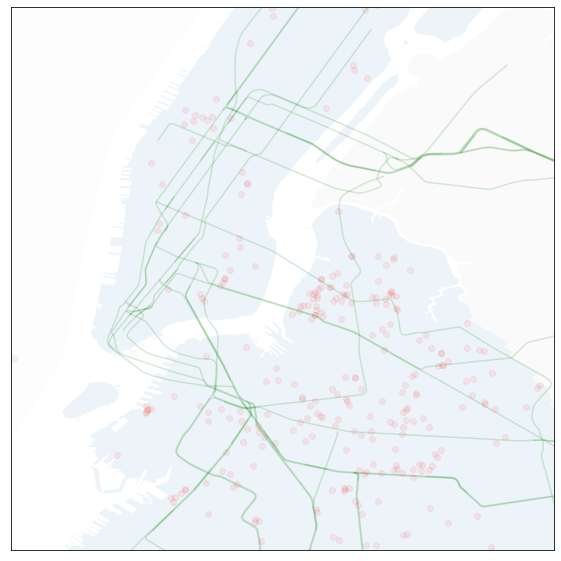

In [186]:
error_list = np.abs(np.transpose( 
    1 - np.abs(np.divide(cur_fit.predict(airbnb[airbnb_output_columns]), airbnb.log_price.values))                             
))

max_error = np.max(np.abs(error_list))

ax = make_base_plot()
airbnb[ error_list > 0.525 * max_error ].drop_duplicates(subset=["id", "geometry"]).plot(ax=ax, alpha=0.07, color="red")


In [169]:
list(reversed(sorted(zip(airbnb_output_columns,cur_fit.coef_), key=lambda zz: abs(zz[1]))))


[('bathrooms', 0.0471448820618482),
 ('is_brooklyn', -0.04434390217452417),
 ('accommodates', 0.04137922046772654),
 ('is_brooklyn_bedrooms', 0.029976687016501455),
 ('is_loft', 0.029591122736524953),
 ('is_brooklyn_beds', -0.026795047235257857),
 ('bedrooms', 0.02515750520583728),
 ('is_brooklyn_bedrooms_per_bathrooms', -0.02437079139560384),
 ('bedrooms_per_bathrooms', 0.01907412862305713),
 ('years_since_2015_squared', 0.014752459968490545),
 ('years_since_2015', -0.014427643816530179),
 ('accommodates_squared', -0.01305573660629352),
 ('is_brooklyn_accommodates', -0.012517618419289209),
 ('is_brooklyn_years_since_2015', -0.01233412033057118),
 ('is_brooklyn_log_beds_per_bedrooms', 0.011079238840596615),
 ('is_house', -0.011052950597595578),
 ('beds', 0.010397947738024152),
 ('log_beds_per_bedrooms_squared', -0.008756034472122072),
 ('is_condominium', 0.00848430608220768),
 ('is_brooklyn_is_house', 0.007909199688591865),
 ('is_brooklyn_is_townhouse', -0.005874774611723916),
 ('is_br

In [170]:
trains_columns = [
    *airbnb_columns,
    'norm_unique_lines',
    'is_brooklyn_norm_unique_lines',
    'log_trains_dist',
    'is_brooklyn_log_trains_dist',
    'log_trains_count',
    'is_brooklyn_log_trains_count',
]

train_output_columns, train_fit = fit_data(airbnb, trains_columns)


['is_august', 'is_january', 'is_march', 'is_summer', 'month', 'month_squared', 'is_brooklyn_accommodates_squared', 'is_brooklyn_bathrooms', 'is_brooklyn_bedrooms', 'is_brooklyn_is_december', 'is_brooklyn_is_january', 'is_brooklyn_is_may', 'is_brooklyn_is_november', 'is_brooklyn_is_september', 'is_brooklyn_is_summer', 'is_brooklyn_is_winter', 'is_brooklyn_years_since_2015_squared', 'is_brooklyn_log_trains_dist', 'is_brooklyn_is_april', 'is_brooklyn_is_february', 'is_brooklyn_is_october', 'is_brooklyn_month', 'is_april', 'is_brooklyn_is_august', 'is_brooklyn_is_june', 'is_june', 'is_september', 'log_beds_per_bedrooms', 'is_february']
[0.43343037275297736, 0.43112180012853574, 0.430308211143545, 0.43024311739260457, 0.4338122732197587, 0.43200876960047224, 0.4322793949900856, 0.43043846459186597]
[0.4268163238971943, 0.436214695943351, 0.4396856909370539, 0.43963106984798556, 0.42554594214950436, 0.4329473711732663, 0.4318320293366049, 0.4394802683498597]


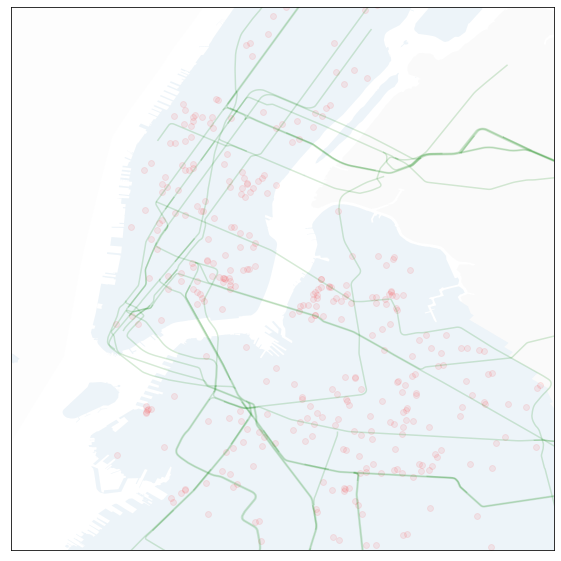

In [188]:
error_list = np.abs(np.transpose( 
    1 - np.abs(np.divide(train_fit.predict(airbnb[train_output_columns]), airbnb.log_price.values))                             
))

max_error = np.max(np.abs(error_list))

ax = make_base_plot()
airbnb[ error_list > 0.525 * max_error ].drop_duplicates(subset=["id", "geometry"]).plot(ax=ax, alpha=0.07, color="red")


In [172]:
list(reversed(sorted(zip(train_output_columns,train_fit.coef_), key=lambda zz: abs(zz[1]))))


[('is_brooklyn', -0.12532887707395315),
 ('is_brooklyn_norm_unique_lines', -0.06100669926245972),
 ('is_brooklyn_log_trains_count', 0.04811893399074855),
 ('bathrooms', 0.04454956423839631),
 ('accommodates', 0.041291035251363274),
 ('bedrooms', 0.03912362217298605),
 ('norm_unique_lines', 0.03149413176380493),
 ('is_loft', 0.02459335873504078),
 ('log_trains_count', 0.020146565734628714),
 ('is_brooklyn_bedrooms_per_bathrooms', -0.015815095580377),
 ('accommodates_squared', -0.014692878461452463),
 ('years_since_2015_squared', 0.0139145431950996),
 ('years_since_2015', -0.013564677772162333),
 ('bedrooms_per_bathrooms', 0.012640799679551923),
 ('is_house', -0.012034459796642171),
 ('is_brooklyn_is_house', 0.011192928314445162),
 ('is_condominium', 0.009970567980634159),
 ('is_brooklyn_years_since_2015', -0.009167448696654376),
 ('log_trains_dist', 0.009074353518894088),
 ('is_brooklyn_log_beds_per_bedrooms_squared', -0.00779555725039515),
 ('is_brooklyn_is_townhouse', -0.0067869105456

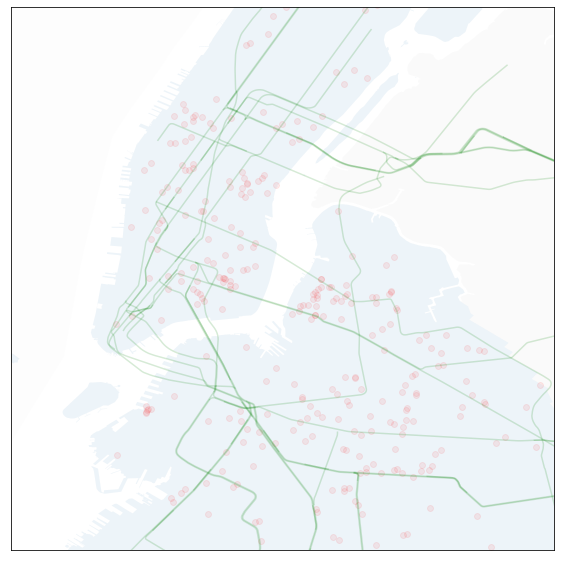

In [173]:
ax = make_base_plot()
airbnb[ error_list > 0.525 * max_error ].drop_duplicates(subset=["id", "geometry"]).plot(ax=ax, alpha=0.07, color="red")

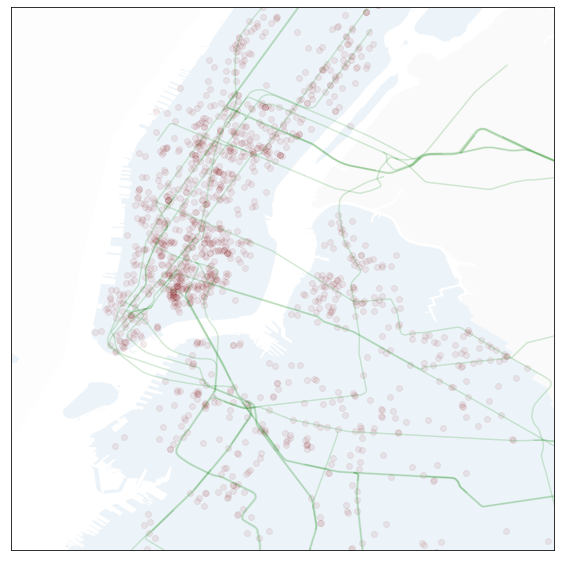

In [174]:
ax = make_base_plot()
cafes.drop_duplicates().plot(ax=ax, c='maroon', alpha=0.07)


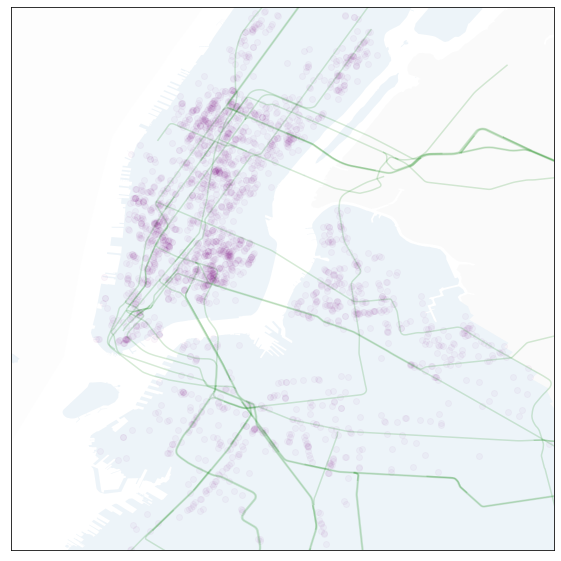

In [175]:
ax = make_base_plot()
bars.drop_duplicates().plot(ax=ax, c="purple", alpha=0.03)


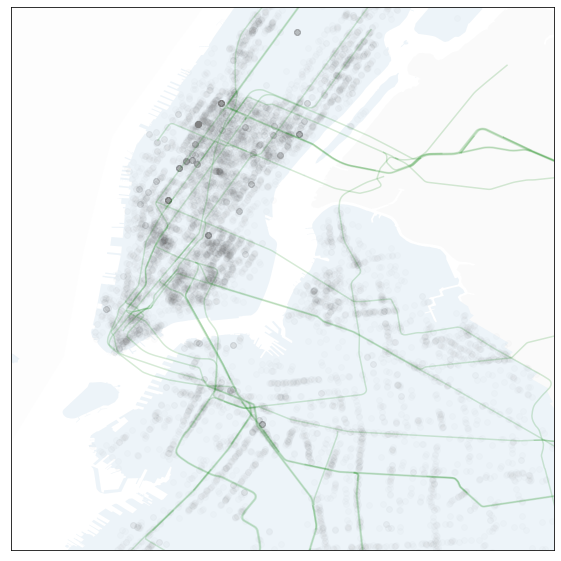

In [176]:
ax = make_base_plot()
food.plot(ax=ax, c='grey', alpha=0.02)


In [182]:
extra_columns = [
    *trains_columns,
    'norm_unique_food',
    'log_cafes_dist',
    'log_bars_dist',
    'log_food_dist',
    'log_cafes_count',
    'log_bars_count',
    'log_food_count',
    'is_brooklyn_norm_unique_food',
    'is_brooklyn_log_cafes_dist',
    'is_brooklyn_log_bars_dist',
    'is_brooklyn_log_food_dist',
    'is_brooklyn_log_cafes_count',
    'is_brooklyn_log_bars_count',
    'is_brooklyn_log_food_count',
]

extra_output_columns, extra_fit = fit_data(airbnb, extra_columns)


['is_april', 'is_august', 'is_brooklyn', 'is_january', 'is_june', 'is_november', 'is_summer', 'month', 'month_squared', 'is_brooklyn_accommodates_squared', 'is_brooklyn_bathrooms', 'is_brooklyn_bedrooms', 'is_brooklyn_beds', 'is_brooklyn_is_april', 'is_brooklyn_is_december', 'is_brooklyn_is_january', 'is_brooklyn_is_june', 'is_brooklyn_is_may', 'is_brooklyn_is_october', 'is_brooklyn_is_september', 'is_brooklyn_is_winter', 'is_brooklyn_month_squared', 'is_brooklyn_years_since_2015', 'is_brooklyn_log_food_dist', 'is_february', 'is_may', 'log_beds_per_bedrooms', 'is_brooklyn_is_november', 'is_brooklyn_is_summer', 'is_brooklyn_years_since_2015_squared', 'beds', 'is_september', 'is_brooklyn_is_august', 'norm_unique_lines', 'is_house']
[0.5091748556330495, 0.5083348939920197, 0.5127325786721011, 0.5109498384274604, 0.509132129767053, 0.510387626154813]
[0.5123096987726936, 0.5156775239638439, 0.4977794974635946, 0.5053333925979785, 0.5129901330779361, 0.5103366959136725]


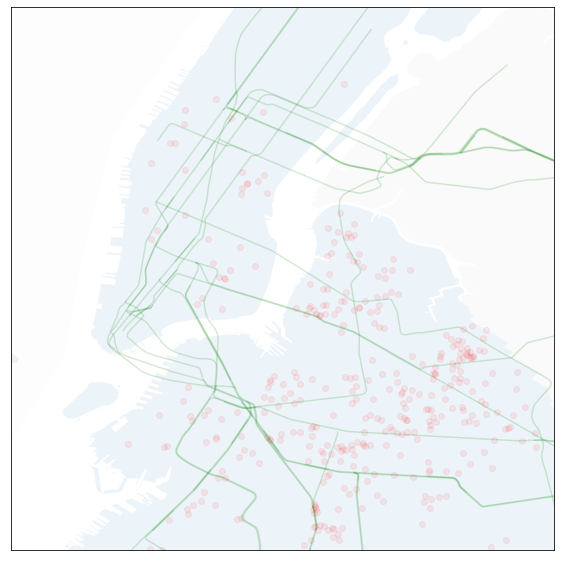

In [192]:
error_list = np.abs(np.transpose( 
    1 - np.abs(np.divide(extra_fit.predict(airbnb[extra_output_columns]), airbnb.log_price.values))                             
))

max_error = np.max(np.abs(error_list))

ax = make_base_plot()
airbnb[ error_list > 0.55 * max_error ].drop_duplicates(subset=["id", "geometry"]).plot(ax=ax, alpha=0.07, color="red")


In [184]:
list(reversed(sorted(zip(extra_output_columns,extra_fit.coef_), key=lambda zz: abs(zz[1]))))


[('is_brooklyn_norm_unique_food', 0.2226170498229594),
 ('is_brooklyn_log_food_count', 0.15945574224787346),
 ('accommodates', 0.05289052146590815),
 ('is_brooklyn_log_bars_count', 0.04921349817482319),
 ('bedrooms', 0.04497428834344243),
 ('norm_unique_food', -0.040229895431027285),
 ('bathrooms', 0.03930614711185752),
 ('log_bars_count', 0.029273439116499652),
 ('is_loft', 0.021966629968410336),
 ('accommodates_squared', -0.02116426005737246),
 ('is_brooklyn_log_cafes_dist', -0.019226132561888206),
 ('is_brooklyn_log_trains_dist', 0.01790533119724951),
 ('is_brooklyn_log_cafes_count', -0.017762899837419757),
 ('years_since_2015_squared', 0.016251406485018164),
 ('is_brooklyn_log_bars_dist', -0.015795296822695735),
 ('log_cafes_count', 0.015788208321107392),
 ('years_since_2015', -0.014570431257509902),
 ('is_brooklyn_bedrooms_per_bathrooms', -0.013815719458532086),
 ('is_brooklyn_norm_unique_lines', -0.012516769676559047),
 ('is_brooklyn_log_trains_count', -0.01137644240978368),
 ('i

In [196]:
separated_columns = [ cur_col for cur_col in extra_columns if "brooklyn" not in cur_col ]
bkn_output_columns, bkn_fit = fit_data(airbnb[airbnb.is_brooklyn], separated_columns)
nyc_output_columns, nyc_fit = fit_data(airbnb[~airbnb.is_brooklyn], separated_columns)


['is_april', 'is_january', 'is_may', 'is_november', 'is_september', 'month_squared', 'is_august', 'is_summer', 'month']
[0.48770197107076185, 0.4901354973853486, 0.4882580003290394, 0.4896311589541992]
[0.49472293036659004, 0.48494763544107905, 0.4925366609775145, 0.4874232280031806]
['is_april', 'is_january', 'is_november', 'month', 'month_squared', 'beds', 'is_august', 'is_june', 'is_september']
[0.4889065943222634, 0.49040727273208484, 0.4890236700067997, 0.48878707130795623]
[0.48988791026330586, 0.4841344648487091, 0.4893603845455711, 0.4907513255217376]


In [203]:
airbnb["latitude"] = airbnb.geometry.centroid.y
airbnb["longitude"] = airbnb.geometry.centroid.x
airbnb["latitude_longitude"] = airbnb.latitude * airbnb.longitude

In [205]:

geo_columns = [
    *extra_columns,
    'latitude',
    'longitude',
    'latitude_longitude'
]

geo_output_columns, geo_fit = fit_data(airbnb, geo_columns)


['is_april', 'is_january', 'is_may', 'is_september', 'month_squared', 'is_brooklyn_accommodates_squared', 'is_brooklyn_bathrooms', 'is_brooklyn_bedrooms', 'is_brooklyn_is_april', 'is_brooklyn_is_condominium', 'is_brooklyn_is_december', 'is_brooklyn_is_january', 'is_brooklyn_is_loft', 'is_brooklyn_is_november', 'is_brooklyn_is_september', 'is_brooklyn_is_summer', 'is_brooklyn_is_winter', 'is_brooklyn_month_squared', 'is_brooklyn_years_since_2015', 'is_brooklyn_norm_unique_lines', 'is_brooklyn_log_bars_dist', 'is_brooklyn_log_food_dist', 'latitude', 'is_february', 'is_house', 'is_june', 'is_november', 'log_beds_per_bedrooms', 'month', 'is_brooklyn_is_august', 'is_brooklyn_is_february', 'is_brooklyn_is_june', 'is_brooklyn_is_may', 'is_brooklyn_log_trains_count', 'is_brooklyn_log_cafes_count', 'beds', 'is_summer']
[0.5202228318419906, 0.521309495833172, 0.5224452925886536, 0.5227013793469294, 0.5227047259605662]
[0.526476374092641, 0.5222535940150415, 0.5173598389276857, 0.5167642729225137

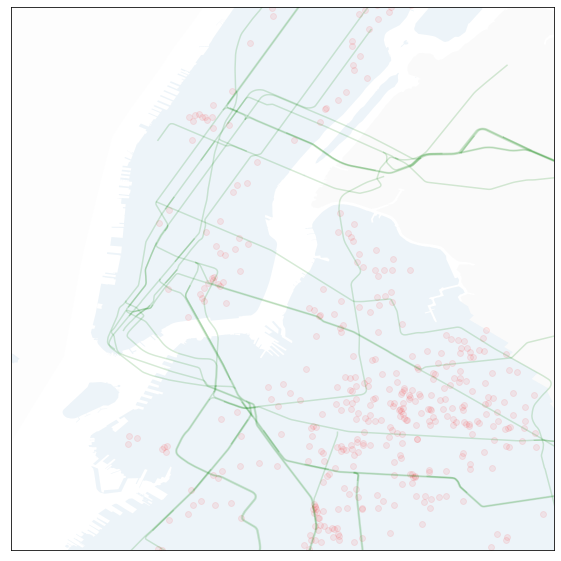

In [209]:
error_list = np.abs(np.transpose( 
    1 - np.abs(np.divide(geo_fit.predict(airbnb[geo_output_columns]), airbnb.log_price.values))                             
))

max_error = np.max(np.abs(error_list))

ax = make_base_plot()
airbnb[ error_list > 0.8 * max_error ].drop_duplicates(subset=["id", "geometry"]).plot(ax=ax, alpha=0.07, color="red")
